In [1]:
import json
from utils.gho_filter import filter_gho_users

with open('results.json', 'r') as fp:
    res = json.load(fp)
data = []
for entry in res:
    data += entry['data']['users']

gho_users = set(filter_gho_users(data))

In [2]:
def get_gho_usage(history: dict, action: str) -> bool:
    for action in history[action]:
        if 'reserve' in action:
            if action['reserve']['symbol'] == 'GHO':
                return True
    return False

transactions = []
histories = ['borrowHistory']
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            transactions += [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
user_transactions = {}
first_transactions = {}
full_transactions = {}
mint_transactions = set()
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
            user_transactions[entry['id']] = len(user_gho_transactions)
            mint_transactions |= set(user_gho_transactions)
            first_transaction = min([c['timestamp'] for c in entry[history] if c['reserve']['symbol'] == 'GHO'])
            first_transactions[entry['id']] = first_transaction
            full_transactions[entry['id']] = [c for c in entry[history] if c['reserve']['symbol'] == 'GHO']

## Number of GHO mints per user

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

In [4]:
df_txs = pd.DataFrame.from_dict(user_transactions, orient='index').reset_index()
df_txs.columns = ['user', 'count']

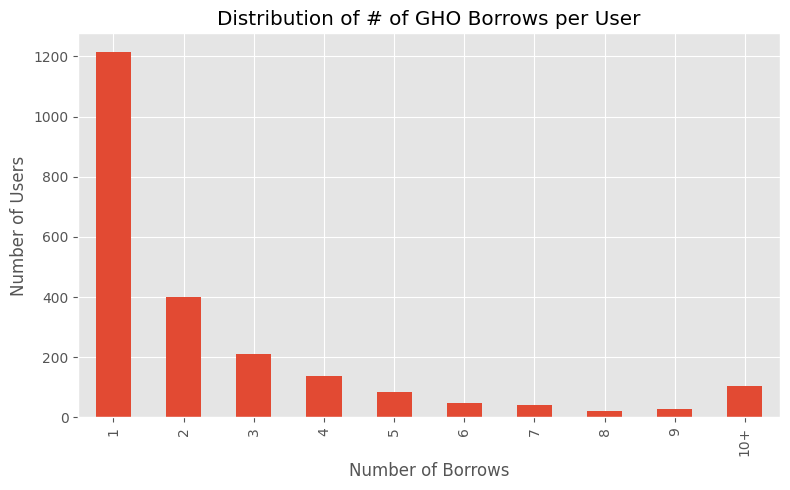

In [5]:
df_txs['count'] = np.where(df_txs['count'] > 10, 10, df_txs['count'])
counts = df_txs['count'].value_counts().sort_index()
counts = counts.rename(index={10: '10+'})

fig, ax = plt.subplots(figsize=(8, 5))
counts.plot(kind='bar', ax=ax)

ax.set_xlabel('Number of Borrows')
ax.set_ylabel('Number of Users')
ax.set_title('Distribution of # of GHO Borrows per User')

plt.tight_layout()
plt.show()

## Survival Rates

We'll look at the first tokens borrowed by all V3 users and calculate the probability that they borrow again and how many times.

## User categorization

We want to see the number of users who:
- have never used GHO
- have started by borrowing GHO and then borrowed other tokens
- have starts with other tokens but then borrowed GHO
- have only ever used GHO

In [6]:
user_type = {}
for history in histories:
    for entry in data:
        user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
        user_ordered_tx = sorted([c for c in entry[history]], key=lambda x: x['timestamp'])
        if len(user_gho_transactions) == 0:
            user_type[entry['id']] = "Never borrowed GHO"
        elif len(user_gho_transactions) == len(user_ordered_tx):
            user_type[entry['id']] = "Only borrowed GHO"
        elif user_ordered_tx[0]['reserve']['symbol'] == 'GHO':
            user_type[entry['id']] = "Started with GHO"
        else:
            user_type[entry['id']] = "Started with other token"


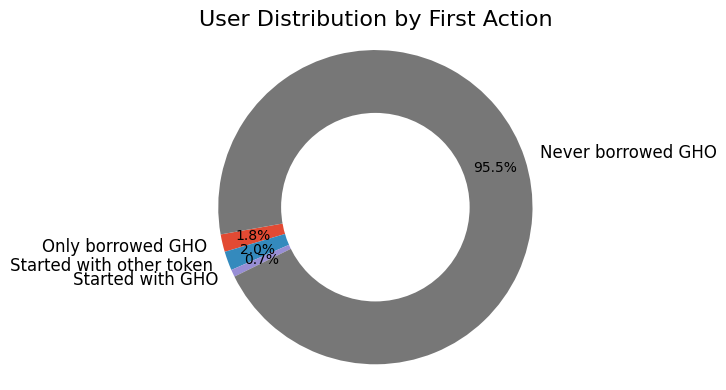

In [7]:
user_type_counts = {type: list(user_type.values()).count(type) for type in set(user_type.values())}
total_users = sum(user_type_counts.values())

labels = list(user_type_counts.keys())
sizes = [count / total_users * 100 for count in user_type_counts.values()]

fig, ax = plt.subplots(figsize=(6, 4))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=190, pctdistance=0.8)

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("User Distribution by First Action", fontsize=16)

plt.setp(autotexts, size=10)
plt.setp(texts, size=12)

plt.tight_layout()
plt.show()

GHO users are a small fraction of the total user base, but let's check the distribution of the categories when we limit ourselves to GHO users only

In [8]:
gho_user_type = {}
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
            user_ordered_tx = sorted([c for c in entry[history]], key=lambda x: x['timestamp'])
            if len(user_gho_transactions) == 0:
                gho_user_type[entry['id']] = "Never borrowed GHO"
            elif len(user_gho_transactions) == len(user_ordered_tx):
                gho_user_type[entry['id']] = "Only borrowed GHO"
            elif user_ordered_tx[0]['reserve']['symbol'] == 'GHO':
                gho_user_type[entry['id']] = "Started with GHO"
            else:
                gho_user_type[entry['id']] = "Started with other token"


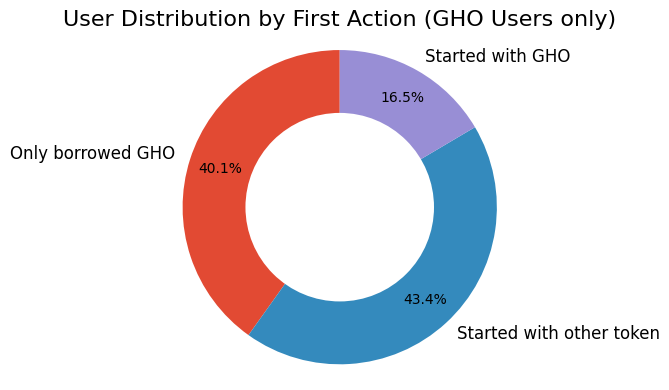

In [9]:
user_type_counts = {type: list(gho_user_type.values()).count(type) for type in set(gho_user_type.values())}
total_users = sum(user_type_counts.values())

labels = list(user_type_counts.keys())
sizes = [count / total_users * 100 for count in user_type_counts.values()]

fig, ax = plt.subplots(figsize=(6, 4))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.8)

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("User Distribution by First Action (GHO Users only)", fontsize=16)

plt.setp(autotexts, size=10)
plt.setp(texts, size=12)

plt.tight_layout()
plt.show()

This would mean that the majority of GHO users are actually new AAVE users. Let's check if those users are indeed new or if they maybe had used AAVE V2 before.
To do so we pull data from the AAVE V2 subgraph using `pull_v2.py`

In [10]:
with open('results_v2.json', 'r') as fp:
    res = json.load(fp)
v2_data = []
for entry in res:
    v2_data += entry['data']['users']

In [11]:
v2_users = set([entry['id'] for entry in v2_data])

In [16]:
import pickle
with open('v2_users.pkl', 'wb') as fp:
    pickle.dump(v2_users, fp)

In [66]:
print(f"GHO Users who had used Aave V2: {len(gho_users & v2_users)} or {len(gho_users & v2_users)/len(gho_users)*100}%")

GHO Users who had used Aave V2: 613 or 26.68698302133217%


Now let's see how many of those overlap with the users who started with other tokens

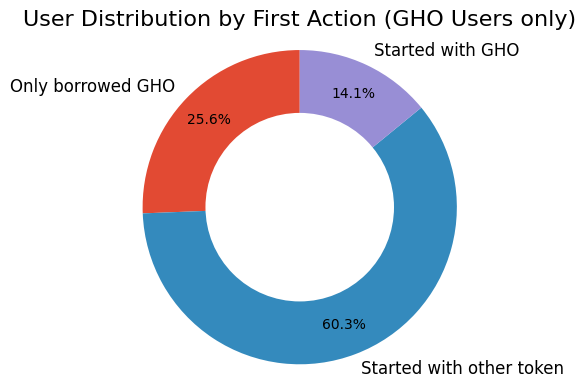

In [12]:
v2_user_type = {k: v for k, v in gho_user_type.items() if k in v2_users}
user_type_counts = {type: list(v2_user_type.values()).count(type) for type in set(v2_user_type.values())}
total_users = sum(user_type_counts.values())

labels = list(user_type_counts.keys())
sizes = [count / total_users * 100 for count in user_type_counts.values()]

fig, ax = plt.subplots(figsize=(6, 4))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.8)

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("User Distribution by First Action (GHO Users only)", fontsize=16)

plt.setp(autotexts, size=10)
plt.setp(texts, size=12)

plt.tight_layout()
plt.show()

Ok, so a good chunk of the new users had actually already used V2 before. Let's redo the chart adding in previous v2 users as a category on its own

In [13]:
user_type = {}
for history in histories:
    for entry in data:
        user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
        user_ordered_tx = sorted([c for c in entry[history]], key=lambda x: x['timestamp'])
        if len(user_gho_transactions) == 0:
            user_type[entry['id']] = "Never borrowed GHO"
        elif entry['id'] in v2_users:
            user_type[entry['id']] = "Started with other token (V2)"            
        elif len(user_gho_transactions) == len(user_ordered_tx):
            user_type[entry['id']] = "Only borrowed GHO"
        elif user_ordered_tx[0]['reserve']['symbol'] == 'GHO':
            user_type[entry['id']] = "Started with GHO"
        else:
            user_type[entry['id']] = "Started with other token (V3)"


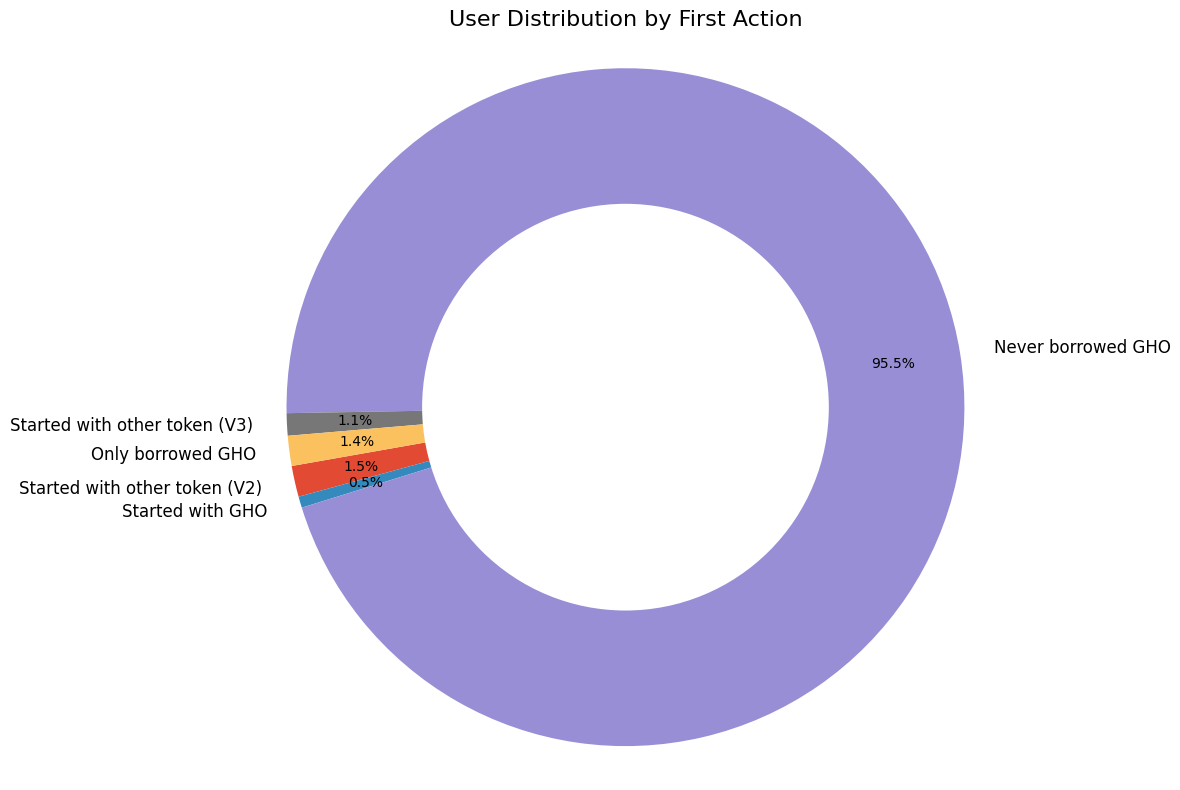

In [14]:
user_type_counts = {type: list(user_type.values()).count(type) for type in set(user_type.values())}
total_users = sum(user_type_counts.values())

labels = list(user_type_counts.keys())
sizes = [count / total_users * 100 for count in user_type_counts.values()]

fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=190, pctdistance=0.8)

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("User Distribution by First Action", fontsize=16)

plt.setp(autotexts, size=10)
plt.setp(texts, size=12)

plt.tight_layout()
plt.show()

{'Started with other token (V3)': 599, 'Only borrowed GHO': 823, 'Started with other token (V2)': 570, 'Started with GHO': 305}
2297


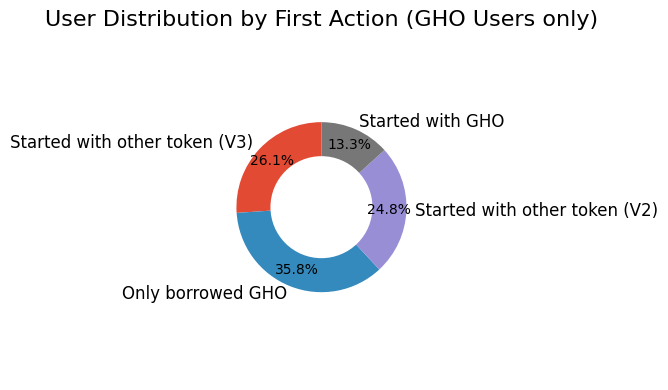

In [83]:
gho_user_type = {}
v2_dict = {v['id']: v for v in v2_data}
gho_only_borrows = []
gho_new_users = []

for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
            user_ordered_tx = sorted([c for c in entry[history]], key=lambda x: x['timestamp'])
            if len(user_gho_transactions) == 0:
                gho_user_type[entry['id']] = "Never borrowed GHO"
            elif (entry['id'] in v2_users) and len(v2_dict[entry['id']][history]) > 0:
                gho_user_type[entry['id']] = "Started with other token (V2)"       
            elif len(user_gho_transactions) == len(user_ordered_tx):
                gho_user_type[entry['id']] = "Only borrowed GHO"
                gho_only_borrows += (user_ordered_tx)
                gho_new_users.append(entry['id'])
            elif user_ordered_tx[0]['reserve']['symbol'] == 'GHO':
                gho_user_type[entry['id']] = "Started with GHO"
                gho_new_users.append(entry['id'])
            else:
                gho_user_type[entry['id']] = "Started with other token (V3)"
                
user_type_counts = {type: list(gho_user_type.values()).count(type) for type in set(gho_user_type.values())}
total_users = sum(user_type_counts.values())
print(user_type_counts)
print(total_users)

labels = list(user_type_counts.keys())
sizes = [count / total_users * 100 for count in user_type_counts.values()]

fig, ax = plt.subplots(figsize=(6, 4))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.8)

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("User Distribution by First Action (GHO Users only)", fontsize=16)

plt.setp(autotexts, size=10)
plt.setp(texts, size=12)

plt.tight_layout()
plt.show()

In [84]:
with open('gho_new_users.pkl', 'wb') as fp:
    pickle.dump(gho_new_users, fp)

In [76]:
len(set([_['caller']['id'] for _ in gho_only_borrows]) & set(v2_users))

94

How does the proportion of users who ONLY use GHO compare to other collaterals?

In [18]:
single_product_users = 0
for history in histories:
    for entry in data:
        borrowed_tokens = list(set([c['reserve']['symbol'] for c in entry[history]]))
        if len(borrowed_tokens) == 1:
            single_product_users += 1

In [23]:
single_product_users / len(data) * 100

31.688454441958154

In [25]:
single_product_users

16144

In [30]:
all_tokens = []
for history in histories:
    for entry in data:
        all_tokens += [c['reserve']['symbol'] for c in entry[history]]

In [31]:
pd.Series(all_tokens).value_counts()

USDC      44881
USDT      40866
WETH      17691
DAI        7656
GHO        6684
WBTC       3615
wstETH     2847
LINK       1178
           1067
RPL        1041
rETH        935
LUSD        922
PYUSD       842
weETH       839
USDe        655
CRV         488
cbETH       456
UNI         453
FRAX        401
crvUSD      339
MKR         310
BAL         281
SNX         198
ENS         192
LDO         184
1INCH       131
ETHx         38
osETH        30
STG          27
FXS          25
KNC          13
dtype: int64

In [82]:
v2_dict = {v['id']: v for v in v2_data}

token = "USDC"
for token in  ["USDC", "USDT", "WETH", "DAI", "wstETH", "WBTC", "GHO", "LUSD", "PYUSD", "CRV", "crvUSD"]:
    user_actions = {}
    for history in histories:
        for entry in data:
            user_transactions = [{'v2': False, **borrow} for borrow in entry[history]]
            if entry['id'] in v2_users:
                user_transactions += [{'v2': True, **borrow} for borrow in v2_dict[entry['id']][history]]
            
            user_ordered_tx = sorted(user_transactions, key=lambda x: x['timestamp'])
    
            user_token_transactions = [c['txHash'] for c in user_transactions if c['reserve']['symbol'] == token]

            if len(user_token_transactions) == 0:
                continue
            elif len(user_token_transactions) == len(user_ordered_tx):
                user_actions[entry['id']] = f"Only ever borrowed {token}"
            elif ((user_ordered_tx[0]['v2'] == True) and (user_ordered_tx[0]['reserve']['symbol'] != token)):
                user_actions[entry['id']] = "Started with other token (V2)"
            elif user_ordered_tx[0]['reserve']['symbol'] == token:
                user_actions[entry['id']] = f"Started with {token}"
            else:
                user_actions[entry['id']] = "Started with other token (V3)"
                
    user_type_counts = {type: list(user_actions.values()).count(type) for type in set(user_actions.values())}
    total_users = sum(user_type_counts.values())
    #print(user_type_counts)
    #print(total_users)
    
    labels = list(user_type_counts.keys())
    sizes = [count / total_users * 100 for count in user_type_counts.values()]
    print("***")
    print(token)
    print(labels)
    print(sizes)
    
    # fig, ax = plt.subplots(figsize=(6, 4))
    # wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.8)
    
    # centre_circle = plt.Circle((0, 0), 0.60, fc='white')
    # fig.gca().add_artist(centre_circle)
    
    # ax.axis('equal')
    # plt.title(f"User Distribution by First Action ({token} Users only)", fontsize=16)
    
    # plt.setp(autotexts, size=10)
    # plt.setp(texts, size=12)
    
    # plt.tight_layout()
    # plt.show()

***
USDC
['Started with other token (V3)', 'Started with USDC', 'Only ever borrowed USDC', 'Started with other token (V2)']
[17.719829120683517, 24.48380206479174, 44.766820932716264, 13.029547881808472]
***
USDT
['Started with other token (V3)', 'Started with other token (V2)', 'Only ever borrowed USDT', 'Started with USDT']
[20.768319178352755, 15.712028441635395, 45.91151491210745, 17.608137467904406]
***
WETH
['Started with other token (V3)', 'Started with WETH', 'Started with other token (V2)', 'Only ever borrowed WETH']
[19.506216074242687, 21.274732971458587, 17.369987742952198, 41.849063211346525]
***
DAI
['Started with other token (V3)', 'Only ever borrowed DAI', 'Started with other token (V2)', 'Started with DAI']
[19.85494106980961, 25.173768510123907, 27.107887579329105, 27.863402840737383]
***
wstETH
['Started with other token (V3)', 'Started with wstETH', 'Started with other token (V2)', 'Only ever borrowed wstETH']
[34.462151394422314, 17.330677290836654, 15.039840637450

In [59]:
user_transactions

[]

For those who start with other tokens, let's see what they usually start with:

In [75]:
v2_dict = {v['id']: v for v in v2_data}

In [79]:
gho_pre_tokens = []
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            user_transactions = [{'v2': False, **borrow} for borrow in entry[history]]
            if entry['id'] in v2_users:
                user_transactions += [{'v2': True, **borrow} for borrow in v2_dict[entry['id']][history]]
            
            user_ordered_tx = sorted(user_transactions, key=lambda x: x['timestamp'])
            user_pre_tokens = []
            for ordered_tx in user_ordered_tx:
                if ordered_tx['reserve']['symbol'] == 'GHO':
                    break
                user_pre_tokens.append(ordered_tx['reserve']['symbol'] + (' (V2)' if ordered_tx['v2'] else ' (V3)'))
            gho_pre_tokens += list(set(user_pre_tokens))

<Axes: title={'center': 'Tokens borrowed prior to GHO'}>

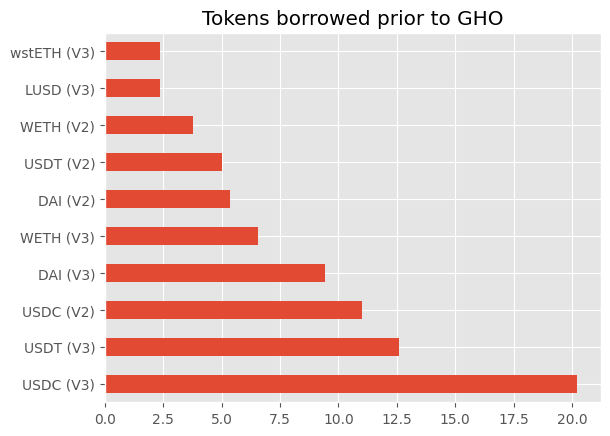

In [97]:
pre_series = pd.Series(gho_pre_tokens)
(pre_series.value_counts() / sum(pre_series.value_counts()) * 100)[:10].plot.barh(title="Tokens borrowed prior to GHO")

## Gateway Tokens

Let's only do the very first token they borrow.

*Note*: On blog do dropdown chart with select GHO/All users/Non GHO user

In [88]:
gho_first_tokens = []
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            user_transactions = [{'v2': False, **borrow} for borrow in entry[history]]
            if entry['id'] in v2_users:
                user_transactions += [{'v2': True, **borrow} for borrow in v2_dict[entry['id']][history]]
            
            user_ordered_tx = sorted(user_transactions, key=lambda x: x['timestamp'])
            ordered_tx = user_ordered_tx[0]
            gho_first_tokens.append(ordered_tx['reserve']['symbol'] + (' (V2)' if ordered_tx['v2'] else ' (V3)'))

<Axes: title={'center': 'First token borrowed by GHO users'}>

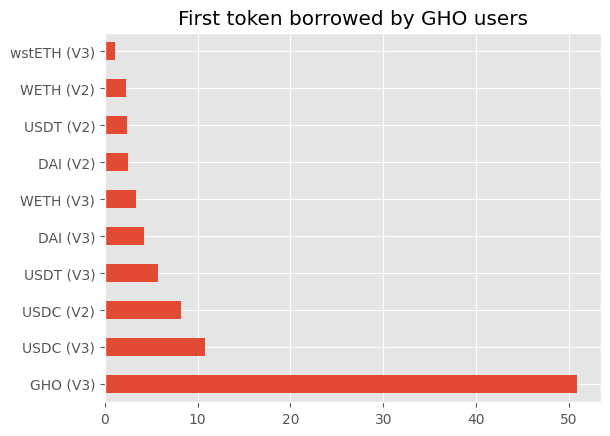

In [89]:
first_series = pd.Series(gho_first_tokens)
(first_series.value_counts() / sum(first_series.value_counts()) * 100)[:10].plot.barh(title="First token borrowed by GHO users")

Let's see if there are any difference compared to what all users start by borrowing

In [92]:
all_first_tokens = []
for history in histories:
    for entry in data:
        if len(entry[history]) > 0:
            user_transactions = [{'v2': False, **borrow} for borrow in entry[history]]
            if entry['id'] in v2_users:
                user_transactions += [{'v2': True, **borrow} for borrow in v2_dict[entry['id']][history]]
            
            user_ordered_tx = sorted(user_transactions, key=lambda x: x['timestamp'])
            ordered_tx = user_ordered_tx[0]
            all_first_tokens.append(ordered_tx['reserve']['symbol'] + (' (V2)' if ordered_tx['v2'] else ' (V3)'))

<Axes: title={'center': 'First token borrowed by all users'}>

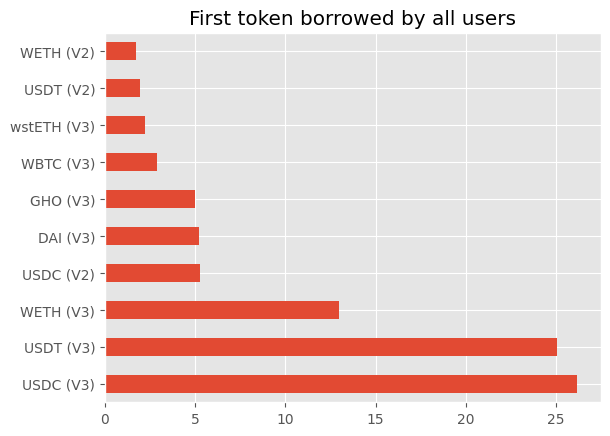

In [93]:
first_series = pd.Series(all_first_tokens)
(first_series.value_counts() / sum(first_series.value_counts()) * 100)[:10].plot.barh(title="First token borrowed by all users")

<Axes: title={'center': 'First token borrowed by all (non-GNO) users'}>

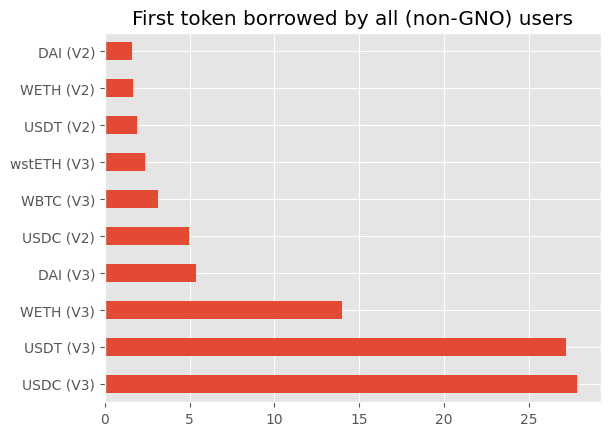

In [94]:
all_first_tokens = []
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            continue
        if len(entry[history]) > 0:
            user_transactions = [{'v2': False, **borrow} for borrow in entry[history]]
            if entry['id'] in v2_users:
                user_transactions += [{'v2': True, **borrow} for borrow in v2_dict[entry['id']][history]]
            
            user_ordered_tx = sorted(user_transactions, key=lambda x: x['timestamp'])
            ordered_tx = user_ordered_tx[0]
            all_first_tokens.append(ordered_tx['reserve']['symbol'] + (' (V2)' if ordered_tx['v2'] else ' (V3)'))

first_series = pd.Series(all_first_tokens)
(first_series.value_counts() / sum(first_series.value_counts()) * 100)[:10].plot.barh(title="First token borrowed by all (non-GNO) users")

Main difference is in the popularity of GNO, unsurprising as one third of GNO users only borrow GNO.
Another is the difference in the popularity of crypto. Only very few users borrow ETH and hardly any borrow BTC when that behavior is otherwise much more common with regular users.